In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

c:\Users\cynthia\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


<a name="2"></a>
## Dataset exploration


In [2]:
# Directory that holds the data
DATA_DIR = './data'

# Subdirectories for each class
data_dir_healthy = os.path.join(DATA_DIR, 'healthy')
data_dir_leaf_curl = os.path.join(DATA_DIR, 'leaf_curl')
data_dir_yellowish = os.path.join(DATA_DIR, 'yellowish')

# os.listdir returns a list containing all files under the given dir
print(f"There are {len(os.listdir(data_dir_healthy))} images of healthy.")
print(f"There are {len(os.listdir(data_dir_leaf_curl))} images of leaf curl.")
print(f"There are {len(os.listdir(data_dir_yellowish))} images of yellowish.")

There are 478 images of healthy.
There are 478 images of leaf curl.
There are 478 images of yellowish.


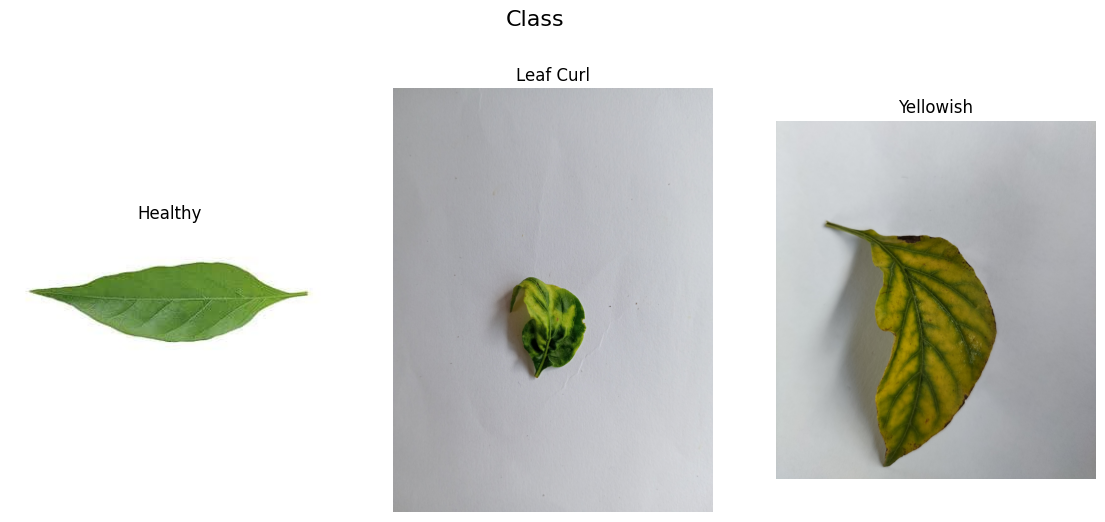

In [3]:
# Get the filenames for cats and dogs images
healthy_filenames = [os.path.join(data_dir_healthy, filename) for filename in os.listdir(data_dir_healthy)]
curl_filename = [os.path.join(data_dir_leaf_curl, filename) for filename in os.listdir(data_dir_leaf_curl)]
yellowish_filename = [os.path.join(data_dir_yellowish, filename) for filename in os.listdir(data_dir_yellowish)]

fig, axes = plt.subplots(1, 3, figsize=(14, 6))  # 1 baris dan 3 kolom untuk 3 kelas
fig.suptitle('Class', fontsize=16)

# Plot satu gambar untuk setiap kelas
healthy_image = tf.keras.utils.load_img(healthy_filenames[0])  # Ambil gambar pertama
axes[0].imshow(healthy_image)
axes[0].set_title('Healthy')

leaf_curl_image = tf.keras.utils.load_img(curl_filename[0])  # Ambil gambar pertama
axes[1].imshow(leaf_curl_image)
axes[1].set_title('Leaf Curl')

yellowish_image = tf.keras.utils.load_img(yellowish_filename[0])  # Ambil gambar pertama
axes[2].imshow(yellowish_image)
axes[2].set_title('Yellowish')

# Hilangkan sumbu untuk tampilan lebih bersih
for ax in axes:
    ax.axis('off')

plt.show()


<a name="ex01"></a>
## train_val_datasets


In [12]:
def train_val_datasets():
   
    training_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=DATA_DIR,
        image_size=(150, 150),
        batch_size=64,
        label_mode='categorical',
        validation_split=0.15,
        subset="training",
        seed=42 
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory( 
        directory=DATA_DIR,
        image_size=(150, 150),
        batch_size=64,
        label_mode='categorical',
        validation_split=0.15,
        subset="validation",
        seed=42 
    )

    return training_dataset, validation_dataset

In [13]:
# Create the datasets
training_dataset, validation_dataset = train_val_datasets()

Found 1434 files belonging to 3 classes.
Using 1219 files for training.
Found 1434 files belonging to 3 classes.
Using 215 files for validation.


In [14]:
# Get the first batch of images and labels
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (64, 150, 150, 3)
Shape of batch of labels: (64, 3)


In [17]:
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([ 
        tf.keras.layers.Input(shape=(150, 150, 3)),
		tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.1)
    ]) 
    
    return augmentation_model

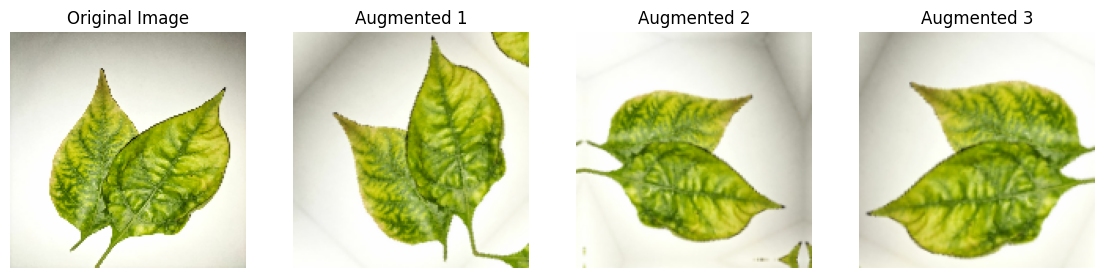

In [20]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch_images[3])

images = [sample_image]

# Apply random augmentation 3 times
for _ in range(3):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [21]:
model = tf.keras.models.Sequential()

augmentation_layers = create_augmentation_model()

# Layer Konvolusi 1
model.add(augmentation_layers)
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Layer Konvolusi 2
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Layer Konvolusi 3
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))

# Layer Fully Connected
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [22]:
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [23]:
try:
	model.evaluate(example_batch_images, example_batch_labels, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function, last layer and label_mode are compatible with one another.")
else:
	predictions = model.predict(example_batch_images, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (64, 3)


In [24]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.9 and logs.get('val_accuracy') >= 0.9:
            self.model.stop_training = True

In [25]:
history = model.fit(
	training_dataset,
	epochs=25,
	validation_data=validation_dataset,
	callbacks = [EarlyStoppingCallback()]
)

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4664 - loss: 74.0147 - val_accuracy: 0.6140 - val_loss: 2.3533
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7477 - loss: 0.9539 - val_accuracy: 0.8093 - val_loss: 0.4963
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8251 - loss: 0.4332 - val_accuracy: 0.8279 - val_loss: 0.5821
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8739 - loss: 0.3422 - val_accuracy: 0.8186 - val_loss: 0.6030
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.9027 - loss: 0.2546 - val_accuracy: 0.9349 - val_loss: 0.2053
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8940 - loss: 0.2783 - val_accuracy: 0.7721 - val_loss: 0.5907
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8602 - loss: 0.3057 - val_accuracy: 0.9442 - val_loss: 0.1997
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9020 - loss: 0.2412 - val_accuracy: 0.9488 - val_loss

In [26]:
# Evaluasi model
loss, accuracy = model.evaluate(validation_dataset)
print(f'Loss: {loss}, Accuracy: {accuracy}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 752ms/step - accuracy: 0.9478 - loss: 0.1485
Loss: 0.13567562401294708, Accuracy: 0.9488372206687927


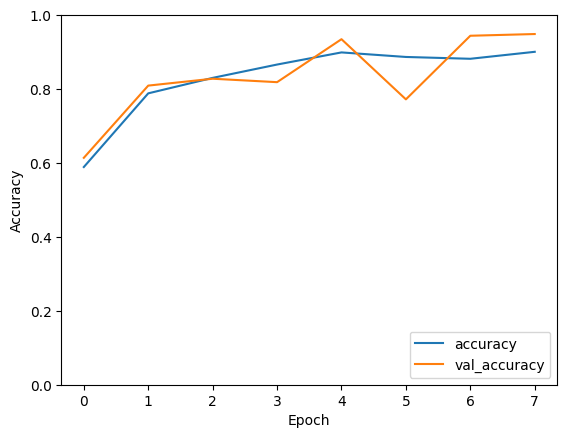

In [27]:
# Visualisasi hasil pelatihan
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

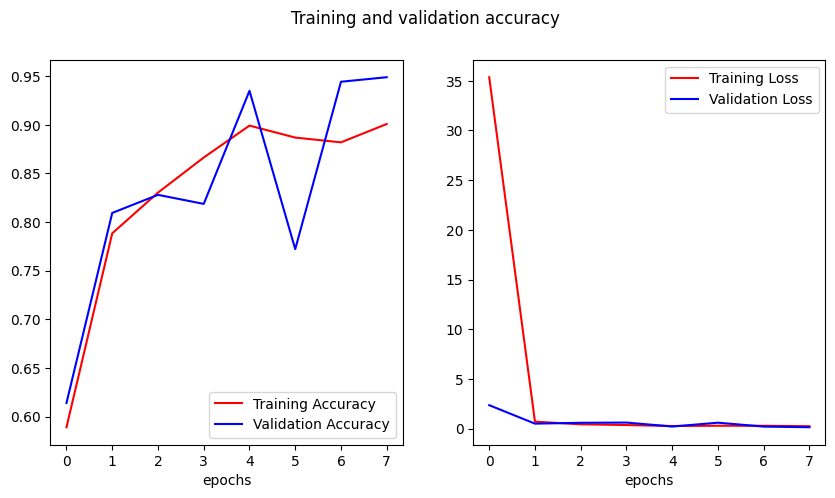

In [28]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [29]:
from ipywidgets import widgets
from io import BytesIO
import tensorflow as tf
import numpy as np
from IPython.display import display

# Widget untuk upload file
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)

# Widget untuk menampilkan output
out = widgets.Output()
display(out)

# Kelas prediksi (disesuaikan dengan model Anda)
classes = ["Healthy", "Leaf Curl", "Yellowish"]

# Fungsi untuk prediksi
def file_predict(filename, file, out_widget):
    """Fungsi untuk memproses file gambar dan membuat prediksi."""
    try:
        # Memuat dan memproses gambar
        image = tf.keras.utils.load_img(file, target_size=(150, 150))
        image = tf.keras.utils.img_to_array(image)
        image = np.expand_dims(image, axis=0)  # Menambahkan dimensi batch

        # Melakukan prediksi
        prediction = model.predict(image, verbose=0)[0]
        prediction_index = np.argmax(prediction)
        predicted_class = classes[prediction_index]
        confidence = prediction[prediction_index]

        # Menampilkan hasil
        with out_widget:
            out_widget.clear_output()  # Membersihkan output sebelumnya
            print(f"\nFile: {filename}")
            print(f"Prediksi: {predicted_class} ({confidence:.2f})")
            print(f"Output Model: {prediction}")

    except Exception as e:
        # Menangani kesalahan
        with out_widget:
            print(f"Error memproses file {filename}: {e}")

# Fungsi untuk menangani perubahan di widget uploader
def on_upload_change(change):
    """Fungsi untuk menangani file yang diunggah."""
    items = change.new  # File yang baru diunggah
    for item in items:  # Memproses setiap file
        try:
            file_jpgdata = BytesIO(item.content)  # Konversi file menjadi stream
            file_predict(item.name, file_jpgdata, out)
        except Exception as e:
            with out:
                print(f"Error membaca file {item.name}: {e}")

# Observasi perubahan pada uploader
uploader.observe(on_upload_change, names="value")

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

In [ ]:
model.save("saved_model/my_model")

In [31]:
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
# Save the model
model.save("chili_model.h5")
print("Model saved as 'chili_model.h5'.")

Model saved as 'model.h5'.


In [23]:
# Konversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/my_model")
tflite_model = converter.convert()

# Simpan model TFLite
with open("model.tflite", "wb") as f:
    f.write(tflite_model)